<a href="https://colab.research.google.com/github/giacomogreggio/computer-vision-project/blob/master/Carvana_image_masking_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking GPU Enabled

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Importing the dependencies

In [2]:
import tensorflow as tf
import math
import numpy as np
from tensorflow import keras
import cv2
import os

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPool2D, ZeroPadding2D, Cropping2D, Softmax, Add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
from PIL import Image

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Preparing the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if "img" not in os.listdir("/content"):
  !unzip "/content/drive/My Drive/Carvana/img_car.zip"
  !unzip "/content/drive/My Drive/Carvana/mask_car.zip"

In [5]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

def open_image(name, path):
    with open(path + '/' + name, 'rb') as f:
        return np.load(f) 

# Important Hyperparameters

In [6]:
DATASET_PATH = '/content'
IMAGE_PATH = DATASET_PATH + '/img'
MASK_PATH = DATASET_PATH + '/mask'

In [7]:
NAMES = os.listdir(IMAGE_PATH)

TRAIN_SPLIT=0.7
VAL_SPLIT=0.2

END_TRAIN_NAMES=int(len(NAMES)*0.7)
END_VAL_NAMES=int(len(NAMES)*(TRAIN_SPLIT+VAL_SPLIT))

TRAIN_NAMES=NAMES[:END_TRAIN_NAMES]
VAL_NAMES=NAMES[END_TRAIN_NAMES:END_VAL_NAMES]
TEST_NAMES=NAMES[END_VAL_NAMES:]

In [8]:
IMAGE_SHAPE = (171, 256, 3)
N_CLASSES = 2

BATCH_SIZE = 40
EPOCHS = 50

TRAIN_LENGTH=len(TRAIN_NAMES)

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS=5
VALIDATION_STEPS = len(VAL_NAMES)//BATCH_SIZE//VAL_SUBSPLITS

L2_VALUE = 5**-4

# Taking a look at the dataset

In [9]:
def print_img(img):
    plt.figure(figsize=(14, 7))
    plt.subplot(1,1,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Lena'), plt.axis('off')
    
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    if (len(display_list)>1 and len(display_list[1].shape)==2):
      display_list[1] = np.expand_dims(display_list[1],axis=2)

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(num=1):
    for i in range(num if num < len(example_images) else len(example_images)):  
        n = len(example_images)-i-1
        pred_mask = create_mask(model(np.expand_dims(example_images[i],axis=0)))
        display([example_images[n], example_masks[n], pred_mask])

In [10]:
number_of_examples = 10

example_images = []
example_masks = []
for i, img_id in enumerate(TEST_NAMES):
    example_images.append(open_image(img_id, IMAGE_PATH))
    example_masks.append(open_image(img_id, MASK_PATH))
    
    if i==number_of_examples:
        break

# Data Generator

In [11]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, image_path, mask_path, to_fit=True, batch_size=32, shuffle=True):
        self.list_IDs = list_IDs
        self.image_path=image_path
        self.mask_path=mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        X = []
        for i, ID in enumerate(list_IDs_temp):
            X.append(open_image(ID, self.image_path))
        return np.array(X)

    def _generate_y(self, list_IDs_temp):
        y = []
        for i, ID in enumerate(list_IDs_temp):
            y.append(open_image(ID, self.mask_path))
        return np.array(y)

# Defining the models

## Defining Custom Layer

In [12]:
class Crop(tf.keras.layers.Layer):
    def call(self, inputs):
        x1, x2 = inputs
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return x1_crop

## Base VGG

In [13]:
def create_base_vgg(trainable=True):
    tf.keras.backend.clear_session()
    
    #Defining Base VGG architecture
    input_layer = Input(shape=(None,None,3), name="input")
    #VGG-block1
    b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_1")(input_layer)
    b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_2")(b1)
    b1 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b1")(b1)

    #VGG-block2
    b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_1")(b1)
    b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_2")(b2)
    b2 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b2")(b2)

    #VGG-block3
    b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_1")(b2)
    b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_2")(b3)
    b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_3")(b3)
    b3 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b3")(b3)

    #VGG-block4
    b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_1")(b3)
    b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_2")(b4)
    b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_3")(b4)
    b4 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b4")(b4)

    #VGG-block5
    b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_1")(b4)
    b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_2")(b5)
    b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_3")(b5)
    b5 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b5")(b5)

    vgg_model = Model(input_layer, b5)
    vgg16= VGG16(weights="imagenet", include_top=False)
    vgg16.save_weights("./weights.h5")
    vgg_model.load_weights("./weights.h5")
    vgg_model.trainable=trainable

    return vgg_model

## FCN-32

In [14]:
def create_fcn32(vgg_trainable=True, include_top=True):
    vgg_model=create_base_vgg(trainable=vgg_trainable)
    b5=vgg_model.layers[-1].output
    input_layer=vgg_model.layers[0].output
    fcn_32_block = Conv2D(4096, kernel_size=(7,7), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_1")(b5)
    fcn_32_block = Dropout(0.5, name="dropout_fcn32_1")(fcn_32_block)
    fcn_32_block = Conv2D(4096, kernel_size=(1,1), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_2")(fcn_32_block)
    fcn_32_block = Dropout(0.5, name="dropout_fcn32_2")(fcn_32_block)
    fcn_32_block = Conv2D(N_CLASSES, kernel_size=(1,1), padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_3")(fcn_32_block)
    if include_top:
        fcn_32_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(64,64), strides=(32,32), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn32")(fcn_32_block)
        fcn_32_crop = Crop()([fcn_32_deconv,input_layer])
        fcn_32_softmax=Softmax(name="softmax_fcn32")(fcn_32_crop)
        return Model(input_layer, fcn_32_softmax)
    else:
        return Model(input_layer, fcn_32_block)

## FCN 16

In [15]:
def create_fcn16(vgg_trainable=True, include_top=True):
    fcn_32=create_fcn32(vgg_trainable=vgg_trainable, include_top=False)
    input_layer=fcn_32.layers[0].output
    b4=fcn_32.get_layer("maxpool_b4").output
    fcn_32_block=fcn_32.layers[-1].output

    fcn_16_block_fcn32 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_1")(fcn_32_block)
    fcn_16_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn16_1")(b4)

    fcn_16_block_fcn32 = Crop()([fcn_16_block_fcn32,fcn_16_block])

    fcn_16_block = Add(name="add_fcn16")([fcn_16_block_fcn32,fcn_16_block])

    if include_top:
        fcn_16_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(32,32), strides=(16,16), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_2")(fcn_16_block)
        fcn_16_crop = Crop()([fcn_16_deconv,input_layer])
        fcn_16_softmax=Softmax(name="softmax_fcn16")(fcn_16_crop)
        return Model(input_layer, fcn_16_softmax)
    else:
        return Model(input_layer, fcn_16_block)

## FCN-8

In [16]:
def create_fcn8(vgg_trainable=True, include_top=True):
    fcn_16=create_fcn16(vgg_trainable=vgg_trainable, include_top=False)
    input_layer=fcn_16.layers[0].output
    b3=fcn_16.get_layer("maxpool_b3").output
    fcn_16_block=fcn_16.layers[-1].output

    fcn_8_block_fcn16 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_1")(fcn_16_block)
    fcn_8_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn8_1")(b3)

    fcn_8_block_fcn16 = Crop()([fcn_8_block_fcn16,fcn_8_block])

    fcn_8_block = Add(name="add_fcn8")([fcn_8_block_fcn16,fcn_8_block])

    if include_top:
        fcn_8_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(16,16), strides=(8,8), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_2")(fcn_8_block)
        fcn_8_crop = Crop()([fcn_8_deconv,input_layer])
        fcn_8_softmax=Softmax(name="softmax_fcn8")(fcn_8_crop)
        return Model(input_layer, fcn_8_softmax)
    else:
        return Model(input_layer, fcn_8_block)

# Training

## Defining custom metrics

In [17]:
class AdaptedMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', n_classes=3,**kwargs):
        super(AdaptedMeanIoU, self).__init__(name=name, **kwargs)
        self.mean_iou=MeanIoU(n_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_converted=tf.argmax(y_pred,axis=-1)
        self.mean_iou.update_state(y_true,y_pred_converted)
        
    def result(self):
        return self.mean_iou.result()
    
    def reset_states(self):
        self.mean_iou.reset_states()

## Defining the Calbacks

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
class print_lr(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Current Learning rate : {}".format(self.model.optimizer.lr.numpy()))

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1**-10)

In [21]:
callbacks=[
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("/content/drive/My Drive/Carvana/best_model_weights.h5", save_best_only=True, verbose=1, save_only_weights=True),
    DisplayCallback(),
    reduce_lr, 
    print_lr(),
]

## Training FCN-8

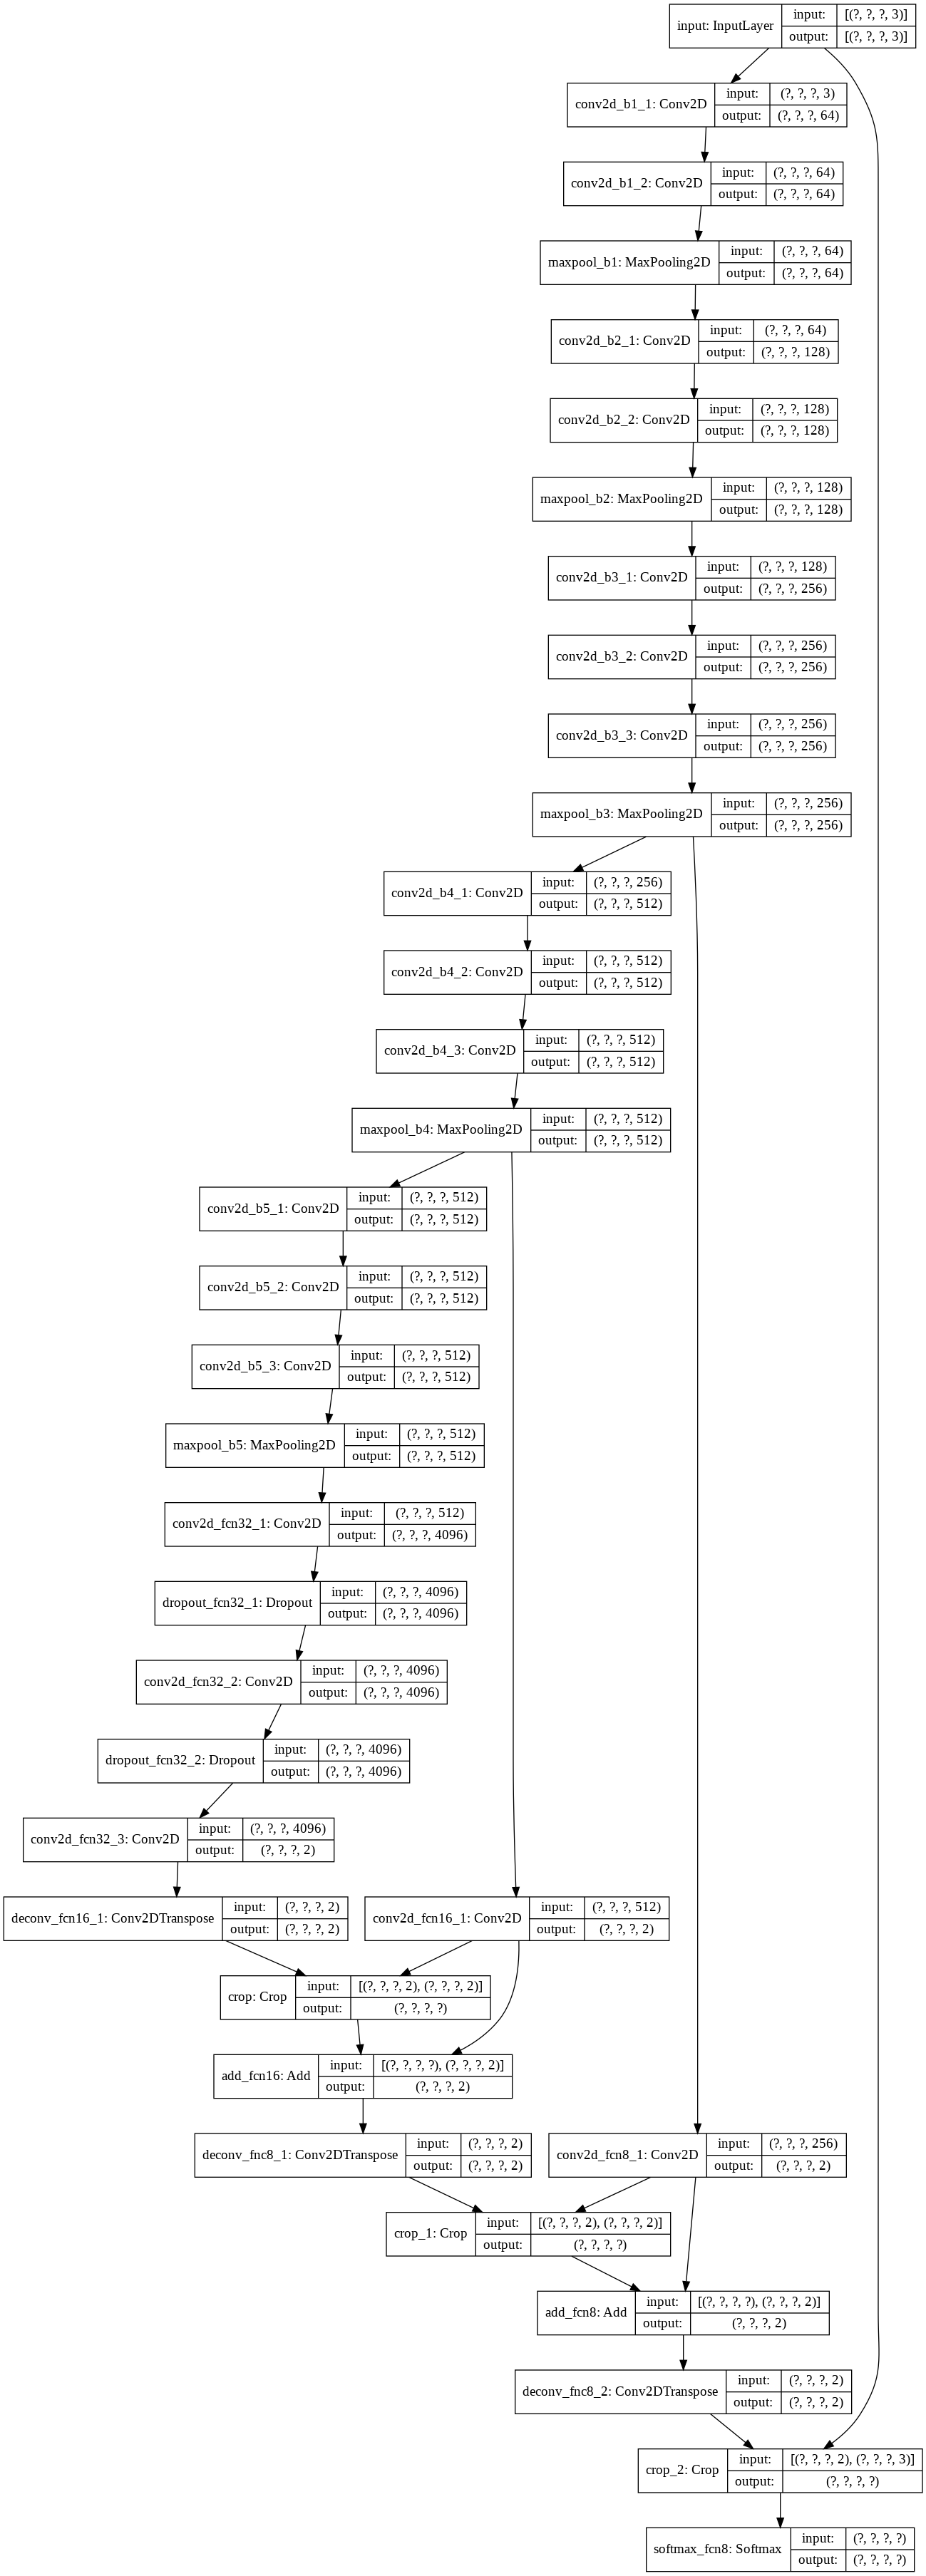

In [22]:
model=create_fcn8()
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, clipnorm=1), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(n_classes=2)])
tf.keras.utils.plot_model(model, show_shapes=True)

Current Learning rate : 0.10000000149011612
Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 1.9942 - mean_iou: 0.9225
Epoch 00001: val_loss improved from 2.76528 to 1.45360, saving model to /content/drive/My Drive/Carvana/best_model_weights.h5


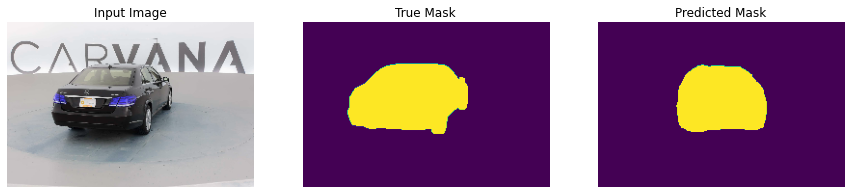


Sample Prediction after epoch 1

89/89 [==============================] - 179s 2s/step - loss: 1.9942 - mean_iou: 0.9225 - val_loss: 1.4536 - val_mean_iou: 0.9549
Current Learning rate : 0.10000000149011612
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 1.1184 - mean_iou: 0.9483
Epoch 00002: val_loss improved from 1.45360 to 0.81918, saving model to /content/drive/My Drive/Carvana/best_model_weights.h5


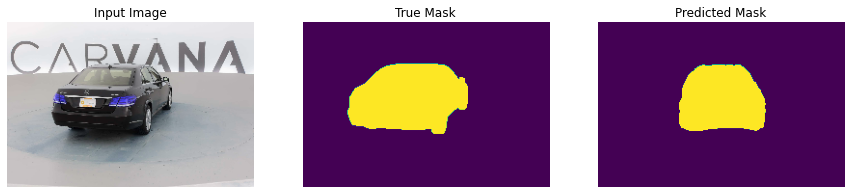


Sample Prediction after epoch 2

89/89 [==============================] - 178s 2s/step - loss: 1.1184 - mean_iou: 0.9483 - val_loss: 0.8192 - val_mean_iou: 0.9643
Current Learning rate : 0.10000000149011612
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.6319 - mean_iou: 0.9615
Epoch 00003: val_loss improved from 0.81918 to 0.46852, saving model to /content/drive/My Drive/Carvana/best_model_weights.h5


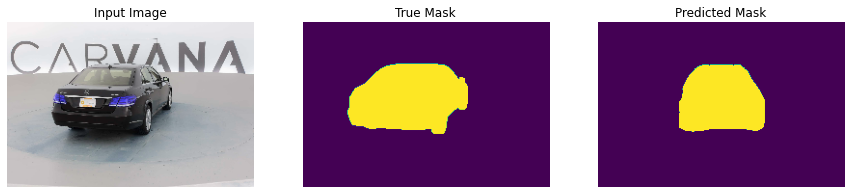


Sample Prediction after epoch 3

89/89 [==============================] - 179s 2s/step - loss: 0.6319 - mean_iou: 0.9615 - val_loss: 0.4685 - val_mean_iou: 0.9665
Current Learning rate : 0.10000000149011612
Epoch 4/50
89/89 [==============================] - ETA: 0s - loss: 0.3664 - mean_iou: 0.9631
Epoch 00004: val_loss improved from 0.46852 to 0.38295, saving model to /content/drive/My Drive/Carvana/best_model_weights.h5


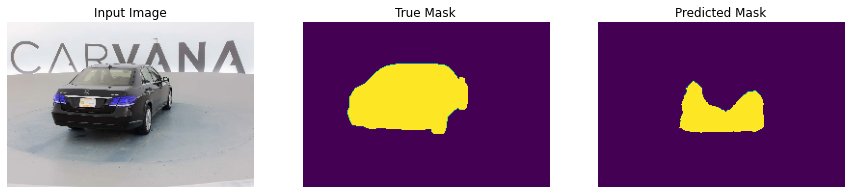


Sample Prediction after epoch 4

89/89 [==============================] - 179s 2s/step - loss: 0.3664 - mean_iou: 0.9631 - val_loss: 0.3829 - val_mean_iou: 0.8893
Current Learning rate : 0.10000000149011612
Epoch 5/50
89/89 [==============================] - ETA: 0s - loss: 0.2463 - mean_iou: 0.9380
Epoch 00005: val_loss improved from 0.38295 to 0.17208, saving model to /content/drive/My Drive/Carvana/best_model_weights.h5


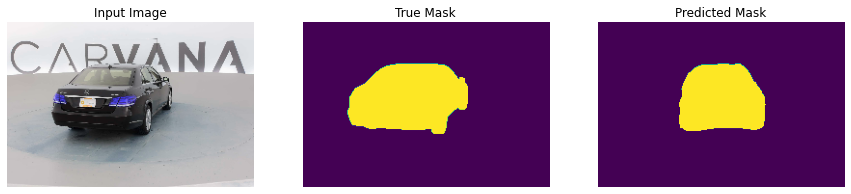


Sample Prediction after epoch 5

89/89 [==============================] - 180s 2s/step - loss: 0.2463 - mean_iou: 0.9380 - val_loss: 0.1721 - val_mean_iou: 0.9638
Current Learning rate : 0.10000000149011612
Epoch 6/50
89/89 [==============================] - ETA: 0s - loss: 0.1350 - mean_iou: 0.9688
Epoch 00006: val_loss improved from 0.17208 to 0.10684, saving model to /content/drive/My Drive/Carvana/best_model_weights.h5


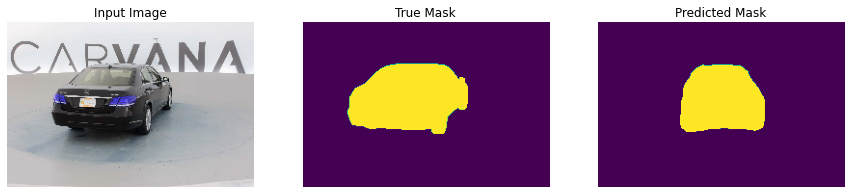


Sample Prediction after epoch 6

89/89 [==============================] - 180s 2s/step - loss: 0.1350 - mean_iou: 0.9688 - val_loss: 0.1068 - val_mean_iou: 0.9690
Current Learning rate : 0.10000000149011612
Epoch 7/50
 9/89 [==>...........................] - ETA: 2:17 - loss: 0.1039 - mean_iou: 0.9698

In [ ]:
generator_train = DataGenerator(TRAIN_NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                          to_fit=True, batch_size=BATCH_SIZE,shuffle=True)

generator_val = DataGenerator(VAL_NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                          to_fit=True, batch_size=BATCH_SIZE,shuffle=True)

model_history = model.fit(generator_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          callbacks=callbacks, validation_data=generator_val)

In [ ]:
show_predictions(10)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])